# Chapter 10 Your data under a different lens: Window functions
we will disucss
- Window functions and the kind of data transformation they enable
- Summarizing, ranking, and analyzing data using the different classes of window functions
- Building static, growing, and unbounded windows to your functions
- Apply UDF to windows as custom window functions

In [2]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings('ignore')

# change the account name to your email account
account='sli'

# define a root path to access the data in the DataAnalysisWithPythonAndPySpark
data_path='/net/clusterhn/home/'+account+'/isa460/data/'

# check if the Spark session is active. If it is activate, close it

try:
    if spark:
        spark.stop()
except:
    pass    

spark = (SparkSession.builder.appName("Multidimensional Data Frame")
        .config("spark.port.maxRetries", "100")
        .config("spark.sql.mapKeyDedupPolicy", "LAST_WIN")  # This configuration allow the duplicate keys in the map data type.
         .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
        .config("spark.driver.memory", "8g")
        .config("spark.driver.executor","8g")
        .getOrCreate())

# confiture the log level (defaulty is WARN)
spark.sparkContext.setLogLevel('ERROR')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/27 07:16:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
25/10/27 07:16:21 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
25/10/27 07:16:21 WARN Utils: Serv

# Weather data
For this exercise, we will use the [National Oceanic and Atmospheric Administration’s (NOAA) Global Surface Summary of the Day (GSOD) data set](https://catalog.data.gov/dataset/global-surface-summary-of-the-day-gsod1). I have downloaed daily Boston weather (Boston Logon weather station 725090) from Google BigQuery. We will focus on weather data in Boston between 2010 and 2024.

In [3]:
# load data
df=spark.read.csv(data_path+'boston_weather', header=True, inferSchema=True)

df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- mo: integer (nullable = true)
 |-- da: integer (nullable = true)
 |-- temp: double (nullable = true)



In [3]:
df.count()

5380

In [4]:
df.show()

+----+---+---+----+
|year| mo| da|temp|
+----+---+---+----+
|2010|  5|  4|70.8|
|2010|  2| 28|33.9|
|2010| 12| 12|41.4|
|2010|  3| 21|50.2|
|2010|  1| 20|34.0|
|2010|  7| 10|77.5|
|2010| 10| 15|52.8|
|2010| 10| 25|52.0|
|2010|  9| 12|60.3|
|2010|  7| 12|74.8|
|2010|  2|  6|23.6|
|2010|  1|  2|28.6|
|2010| 12| 26|27.4|
|2010|  2| 25|40.1|
|2010|  6|  4|65.8|
|2010|  6|  1|69.6|
|2010|  7| 14|73.1|
|2010|  1| 17|37.3|
|2010|  7| 23|75.0|
|2010|  7| 18|83.4|
+----+---+---+----+
only showing top 20 rows



In [4]:
# create a date column based on year, month and day, create another column for year-month

df=df.withColumn('date', F.to_date(F.concat_ws('-', df['year'], df['mo'], df['da']), 'yyyy-MM-dd')).orderBy('date')\
     .withColumn('year_month', F.to_date(F.concat_ws('-', df['year'], df['mo']), 'yyyy-MM')).orderBy('date')

df.limit(10).show()

+----+---+---+----+----------+----------+
|year| mo| da|temp|      date|year_month|
+----+---+---+----+----------+----------+
|2010|  1|  1|29.6|2010-01-01|2010-01-01|
|2010|  1|  2|28.6|2010-01-02|2010-01-01|
|2010|  1|  3|22.3|2010-01-03|2010-01-01|
|2010|  1|  4|30.5|2010-01-04|2010-01-01|
|2010|  1|  5|29.2|2010-01-05|2010-01-01|
|2010|  1|  6|28.7|2010-01-06|2010-01-01|
|2010|  1|  7|30.9|2010-01-07|2010-01-01|
|2010|  1|  8|27.4|2010-01-08|2010-01-01|
|2010|  1|  9|22.9|2010-01-09|2010-01-01|
|2010|  1| 10|17.6|2010-01-10|2010-01-01|
+----+---+---+----+----------+----------+



## Visualize daily temperture

In [7]:
result=df.toPandas()

result.head()

,year,mo,da,temp,date,year_month
0,2010,1,1,29.6,2010-01-01,2010-01-01
1,2010,1,2,28.6,2010-01-02,2010-01-01
2,2010,1,3,22.3,2010-01-03,2010-01-01
3,2010,1,4,30.5,2010-01-04,2010-01-01
4,2010,1,5,29.2,2010-01-05,2010-01-01


<Axes: xlabel='date', ylabel='temp'>

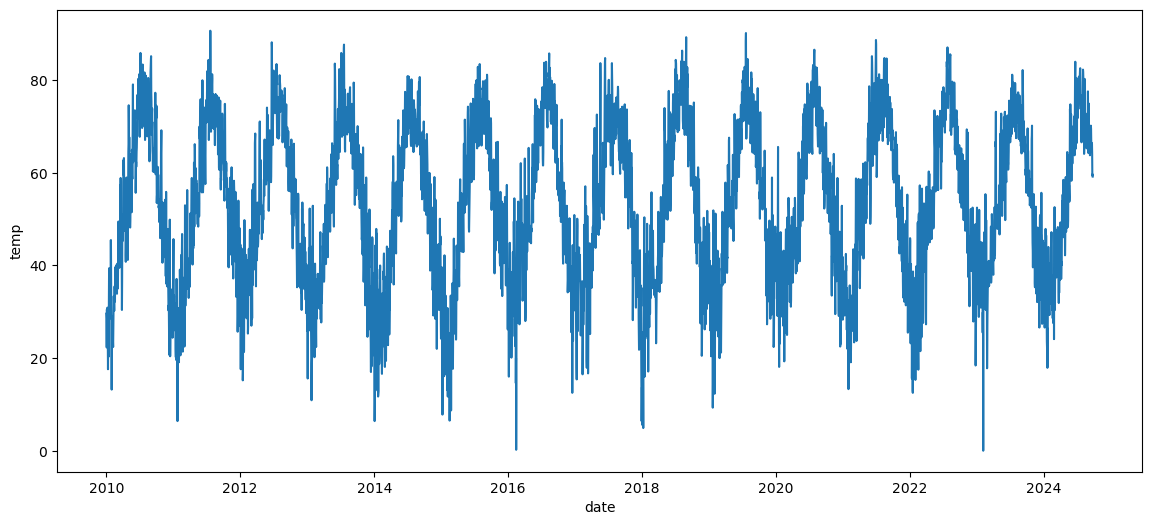

In [8]:
plt.figure(figsize=(14, 6))

sns.lineplot(data=result, x='date', y='temp')

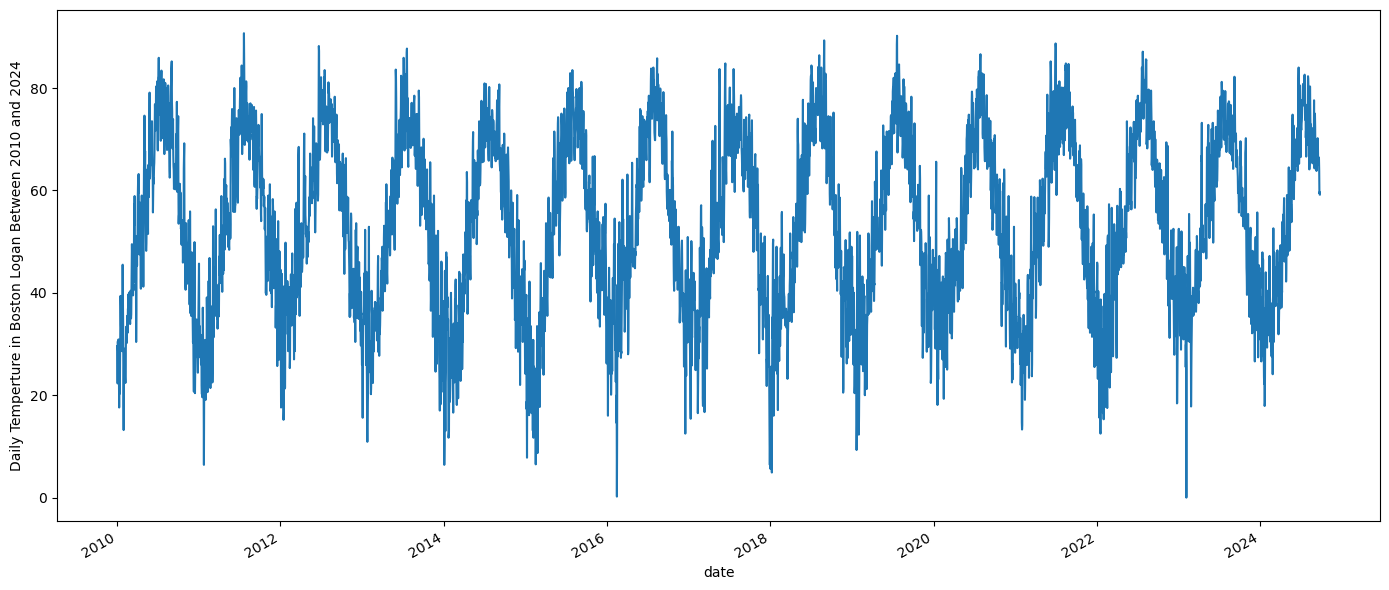

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(result['date'], result['temp'])
ax.set_xlabel('date')
ax.set_ylabel('Daily Temperture in Boston Logan Between 2010 and 2024')

fig.autofmt_xdate()
plt.tight_layout()


## Identify the coldest day of each year

In [10]:
from pyspark.sql.window import Window

windowSpec=Window.partitionBy('year')

result=df.withColumn('coldestDay', F.min('temp').over(windowSpec))

result.where('temp=coldestDay').show()

#result.where('temp=coldestDay').drop('coldestDay').show()

+----+---+---+----+----------+----------+----------+
|year| mo| da|temp|      date|year_month|coldestDay|
+----+---+---+----+----------+----------+----------+
|2010|  1| 30|13.2|2010-01-30|2010-01-01|      13.2|
|2011|  1| 24| 6.4|2011-01-24|2011-01-01|       6.4|
|2012|  1| 15|15.2|2012-01-15|2012-01-01|      15.2|
|2013|  1| 24|10.9|2013-01-24|2013-01-01|      10.9|
|2014|  1|  3| 6.4|2014-01-03|2014-01-01|       6.4|
|2015|  2| 16| 6.5|2015-02-16|2015-02-01|       6.5|
|2016|  2| 14| 0.2|2016-02-14|2016-02-01|       0.2|
|2017| 12| 29| 6.4|2017-12-29|2017-12-01|       6.4|
|2018|  1|  7| 4.9|2018-01-07|2018-01-01|       4.9|
|2019|  1| 21| 9.3|2019-01-21|2019-01-01|       9.3|
|2020|  1| 18|18.1|2020-01-18|2020-01-01|      18.1|
|2021|  1| 30|13.3|2021-01-30|2021-01-01|      13.3|
|2022|  1| 16|12.5|2022-01-16|2022-01-01|      12.5|
|2023|  2|  4| 0.0|2023-02-04|2023-02-01|       0.0|
|2024|  1| 20|17.9|2024-01-20|2024-01-01|      17.9|
+----+---+---+----+----------+----------+-----

## Identify the hottest day of each year

In [11]:
windowSpec=Window.partitionBy('year')

result=df.withColumn('hottestDay', F.max('temp').over(windowSpec))

result.where('temp=hottestDay').show()

#result.where('temp=hottestDay').drop('hottestDay').show()

+----+---+---+----+----------+----------+----------+
|year| mo| da|temp|      date|year_month|hottestDay|
+----+---+---+----+----------+----------+----------+
|2010|  7|  6|85.9|2010-07-06|2010-07-01|      85.9|
|2011|  7| 22|90.7|2011-07-22|2011-07-01|      90.7|
|2012|  6| 21|88.2|2012-06-21|2012-06-01|      88.2|
|2013|  7| 20|87.7|2013-07-20|2013-07-01|      87.7|
|2014|  7|  2|80.9|2014-07-02|2014-07-01|      80.9|
|2015|  7| 30|83.5|2015-07-30|2015-07-01|      83.5|
|2016|  8| 12|85.8|2016-08-12|2016-08-01|      85.8|
|2017|  6| 13|84.8|2017-06-13|2017-06-01|      84.8|
|2018|  8| 29|89.3|2018-08-29|2018-08-01|      89.3|
|2019|  7| 21|90.2|2019-07-21|2019-07-01|      90.2|
|2020|  7| 28|86.6|2020-07-28|2020-07-01|      86.6|
|2021|  6| 29|88.7|2021-06-29|2021-06-01|      88.7|
|2022|  7| 24|87.1|2022-07-24|2022-07-01|      87.1|
|2023|  9|  7|82.2|2023-09-07|2023-09-01|      82.2|
|2024|  6| 20|84.0|2024-06-20|2024-06-01|      84.0|
+----+---+---+----+----------+----------+-----

## Ranking functions

This section covers ranking functions: 
- nonconsecutive ranks with rank()
- consecutive ranks with dense_rank()
- percentile ranks with percent_rank()
- tiles with ntile(), 
- finally a bare row number with row_number()

Ranking functions are used for getting the top (or bottom) record for each window partition, or, more generally, for getting an order according to some column’s value.

### Identify the top 3 hottest days per year

In [7]:
windowSpec=Window.partitionBy('year').orderBy(F.desc('temp'))

#df.withColumn('rank', F.rank().over(windowSpec)).where('rank<=3').show()
df.withColumn('rank', F.rank().over(windowSpec)).filter(F.col('rank')<=3).show()

+----+---+---+----+----------+----------+----+
|year| mo| da|temp|      date|year_month|rank|
+----+---+---+----+----------+----------+----+
|2010|  7|  6|85.9|2010-07-06|2010-07-01|   1|
|2010|  9|  2|85.2|2010-09-02|2010-09-01|   2|
|2010|  9|  1|84.4|2010-09-01|2010-09-01|   3|
|2011|  7| 22|90.7|2011-07-22|2011-07-01|   1|
|2011|  7| 23|85.1|2011-07-23|2011-07-01|   2|
|2011|  7| 12|84.4|2011-07-12|2011-07-01|   3|
|2012|  6| 21|88.2|2012-06-21|2012-06-01|   1|
|2012|  6| 22|87.2|2012-06-22|2012-06-01|   2|
|2012|  7| 17|83.5|2012-07-17|2012-07-01|   3|
|2013|  7| 20|87.7|2013-07-20|2013-07-01|   1|
|2013|  7| 19|86.9|2013-07-19|2013-07-01|   2|
|2013|  7|  5|85.9|2013-07-05|2013-07-01|   3|
|2014|  7|  2|80.9|2014-07-02|2014-07-01|   1|
|2014|  7|  8|80.8|2014-07-08|2014-07-01|   2|
|2014|  9|  6|80.7|2014-09-06|2014-09-01|   3|
|2015|  7| 30|83.5|2015-07-30|2015-07-01|   1|
|2015|  7| 20|82.9|2015-07-20|2015-07-01|   2|
|2015|  9|  8|81.2|2015-09-08|2015-09-01|   3|
|2016|  8| 12

### Identify the top 5% of the hottest day per year

In [13]:
windowSpec=Window.partitionBy('year').orderBy('temp')

df.withColumn('percent_rank', F.percent_rank().over(windowSpec)).where('percent_rank>=0.95').show()

+----+---+---+----+----------+----------+------------------+
|year| mo| da|temp|      date|year_month|      percent_rank|
+----+---+---+----+----------+----------+------------------+
|2010|  7| 19|79.8|2010-07-19|2010-07-01|0.9505494505494505|
|2010|  8|  5|80.0|2010-08-05|2010-08-01|0.9532967032967034|
|2010|  8|  9|80.0|2010-08-09|2010-08-01|0.9532967032967034|
|2010|  6| 24|80.3|2010-06-24|2010-06-01|0.9587912087912088|
|2010|  7| 29|80.3|2010-07-29|2010-07-01|0.9587912087912088|
|2010|  8| 17|80.5|2010-08-17|2010-08-01|0.9642857142857143|
|2010|  7|  9|80.9|2010-07-09|2010-07-01| 0.967032967032967|
|2010|  8|  4|81.0|2010-08-04|2010-08-01|0.9697802197802198|
|2010|  6| 29|81.3|2010-06-29|2010-06-01|0.9725274725274725|
|2010|  7| 28|81.7|2010-07-28|2010-07-01|0.9752747252747253|
|2010|  8| 30|81.8|2010-08-30|2010-08-01| 0.978021978021978|
|2010|  7| 17|81.9|2010-07-17|2010-07-01|0.9807692307692307|
|2010|  7|  4|82.0|2010-07-04|2010-07-01|0.9835164835164835|
|2010|  7|  5|82.3|2010-

### Split the temp per year into 10 equal buckets (decile)

In [14]:
windowSpec=Window.partitionBy('year').orderBy('temp')

df.withColumn('decile', F.ntile(10).over(windowSpec)).groupBy('year', 'decile').count().orderBy('year', 'decile').show()

+----+------+-----+
|year|decile|count|
+----+------+-----+
|2010|     1|   37|
|2010|     2|   37|
|2010|     3|   37|
|2010|     4|   37|
|2010|     5|   37|
|2010|     6|   36|
|2010|     7|   36|
|2010|     8|   36|
|2010|     9|   36|
|2010|    10|   36|
|2011|     1|   37|
|2011|     2|   37|
|2011|     3|   37|
|2011|     4|   37|
|2011|     5|   37|
|2011|     6|   36|
|2011|     7|   36|
|2011|     8|   36|
|2011|     9|   36|
|2011|    10|   36|
+----+------+-----+
only showing top 20 rows



In [15]:
# check the temp in decile (10% of the coldest temperature in each year)

windowSpec=Window.partitionBy('year').orderBy('temp')

df.withColumn('decile', F.ntile(10).over(windowSpec)).where('decile=1').show()

+----+---+---+----+----------+----------+------+
|year| mo| da|temp|      date|year_month|decile|
+----+---+---+----+----------+----------+------+
|2010|  1| 30|13.2|2010-01-30|2010-01-01|     1|
|2010|  1| 10|17.6|2010-01-10|2010-01-01|     1|
|2010|  1| 29|18.6|2010-01-29|2010-01-01|     1|
|2010|  1| 31|19.7|2010-01-31|2010-01-01|     1|
|2010|  1| 13|20.3|2010-01-13|2010-01-01|     1|
|2010| 12| 15|20.4|2010-12-15|2010-12-01|     1|
|2010| 12| 10|20.7|2010-12-10|2010-12-01|     1|
|2010|  1|  3|22.3|2010-01-03|2010-01-01|     1|
|2010|  2|  7|22.4|2010-02-07|2010-02-01|     1|
|2010|  1|  9|22.9|2010-01-09|2010-01-01|     1|
|2010|  2|  6|23.6|2010-02-06|2010-02-01|     1|
|2010| 12| 28|24.4|2010-12-28|2010-12-01|     1|
|2010| 12|  9|24.7|2010-12-09|2010-12-01|     1|
|2010|  1| 11|25.2|2010-01-11|2010-01-01|     1|
|2010| 12| 16|25.2|2010-12-16|2010-12-01|     1|
|2010|  2|  8|26.5|2010-02-08|2010-02-01|     1|
|2010| 12| 27|27.2|2010-12-27|2010-12-01|     1|
|2010|  1|  8|27.4|2

### Add a row number to your data frame, ignore tie

In [8]:
windowSpec=Window.partitionBy('year').orderBy('temp')

df.withColumn('row_number', F.row_number().over(windowSpec)).show()

+----+---+---+----+----------+----------+----------+
|year| mo| da|temp|      date|year_month|row_number|
+----+---+---+----+----------+----------+----------+
|2010|  1| 30|13.2|2010-01-30|2010-01-01|         1|
|2010|  1| 10|17.6|2010-01-10|2010-01-01|         2|
|2010|  1| 29|18.6|2010-01-29|2010-01-01|         3|
|2010|  1| 31|19.7|2010-01-31|2010-01-01|         4|
|2010|  1| 13|20.3|2010-01-13|2010-01-01|         5|
|2010| 12| 15|20.4|2010-12-15|2010-12-01|         6|
|2010| 12| 10|20.7|2010-12-10|2010-12-01|         7|
|2010|  1|  3|22.3|2010-01-03|2010-01-01|         8|
|2010|  2|  7|22.4|2010-02-07|2010-02-01|         9|
|2010|  1|  9|22.9|2010-01-09|2010-01-01|        10|
|2010|  2|  6|23.6|2010-02-06|2010-02-01|        11|
|2010| 12| 28|24.4|2010-12-28|2010-12-01|        12|
|2010| 12|  9|24.7|2010-12-09|2010-12-01|        13|
|2010|  1| 11|25.2|2010-01-11|2010-01-01|        14|
|2010| 12| 16|25.2|2010-12-16|2010-12-01|        15|
|2010|  2|  8|26.5|2010-02-08|2010-02-01|     

## Access the records before or after using lag() and lead()

### Display average daily temp change by month

In [9]:
windowSpec=Window.partitionBy('year', 'mo').orderBy('da')

df2=df.select('year', 'mo', 'da', 'temp', F.lag('temp').over(windowSpec).alias('pre_temp'))

df2.show()

df3=df2.withColumn('daily_temp_change', F.abs(F.col('temp')-F.col('pre_temp')))

df3.show()

df4=df3.groupBy('year', 'mo').agg(F.round(F.avg('daily_temp_change'), 2).alias('avgTempChange'))

df4.show()

+----+---+---+----+--------+
|year| mo| da|temp|pre_temp|
+----+---+---+----+--------+
|2010|  1|  1|29.6|    NULL|
|2010|  1|  2|28.6|    29.6|
|2010|  1|  3|22.3|    28.6|
|2010|  1|  4|30.5|    22.3|
|2010|  1|  5|29.2|    30.5|
|2010|  1|  6|28.7|    29.2|
|2010|  1|  7|30.9|    28.7|
|2010|  1|  8|27.4|    30.9|
|2010|  1|  9|22.9|    27.4|
|2010|  1| 10|17.6|    22.9|
|2010|  1| 11|25.2|    17.6|
|2010|  1| 12|29.3|    25.2|
|2010|  1| 13|20.3|    29.3|
|2010|  1| 14|27.5|    20.3|
|2010|  1| 15|35.6|    27.5|
|2010|  1| 16|39.4|    35.6|
|2010|  1| 17|37.3|    39.4|
|2010|  1| 18|33.7|    37.3|
|2010|  1| 19|32.2|    33.7|
|2010|  1| 20|34.0|    32.2|
+----+---+---+----+--------+
only showing top 20 rows

+----+---+---+----+--------+------------------+
|year| mo| da|temp|pre_temp| daily_temp_change|
+----+---+---+----+--------+------------------+
|2010|  1|  1|29.6|    NULL|              NULL|
|2010|  1|  2|28.6|    29.6|               1.0|
|2010|  1|  3|22.3|    28.6| 6.3000000

#### Visualize the result

In [10]:
df5=df4.withColumn('year_month', F.to_date(F.concat_ws('-', df['year'], df['mo']), 'yyyy-MM'))

df5.show(5)

+----+---+-------------+----------+
|year| mo|avgTempChange|year_month|
+----+---+-------------+----------+
|2010|  1|         4.76|2010-01-01|
|2010|  2|         1.97|2010-02-01|
|2010|  3|         4.36|2010-03-01|
|2010|  4|         4.61|2010-04-01|
|2010|  5|         4.72|2010-05-01|
+----+---+-------------+----------+
only showing top 5 rows



<Axes: xlabel='year_month', ylabel='avgTempChange'>

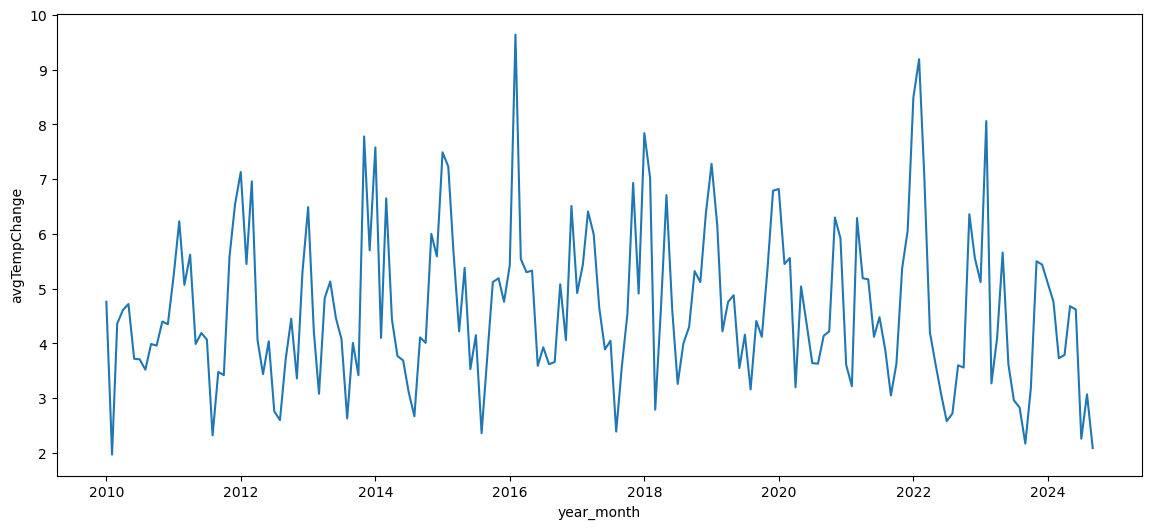

In [11]:
result=df5.toPandas()

plt.figure(figsize=(14, 6))

sns.lineplot(data=result, x='year_month', y='avgTempChange')

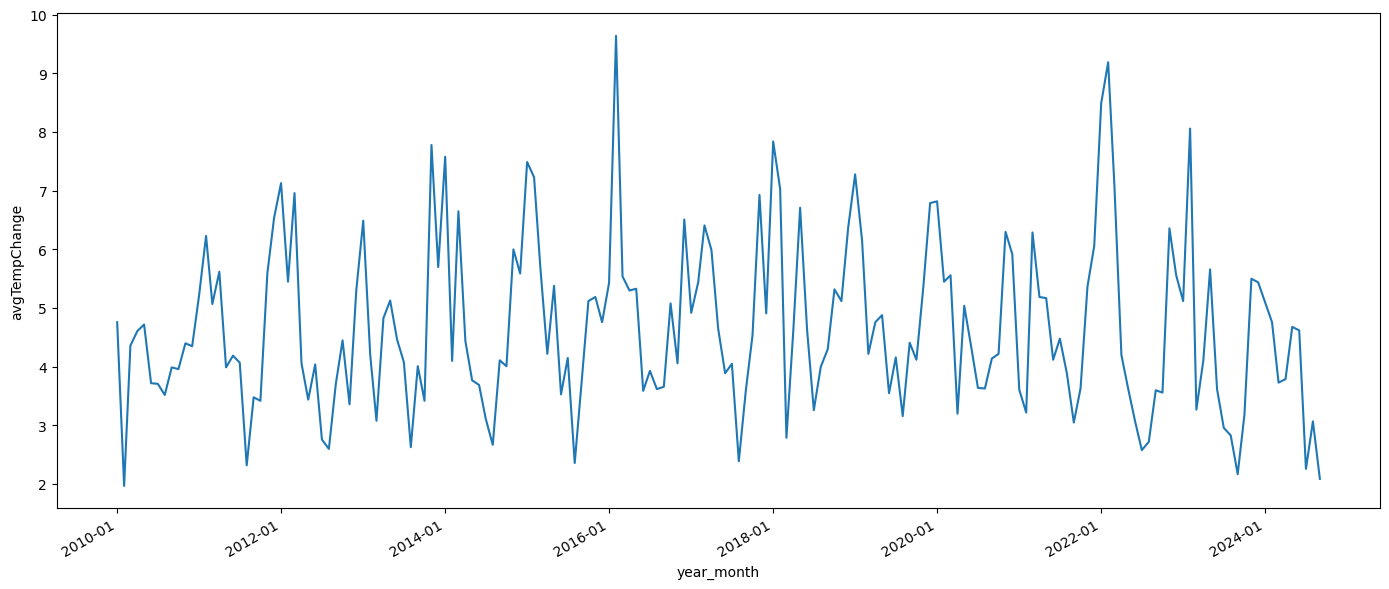

In [20]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

sns.lineplot(data=result, x='year_month', y='avgTempChange')

# Set x-axis date format to show both year and month

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Adjust the layout
plt.tight_layout()

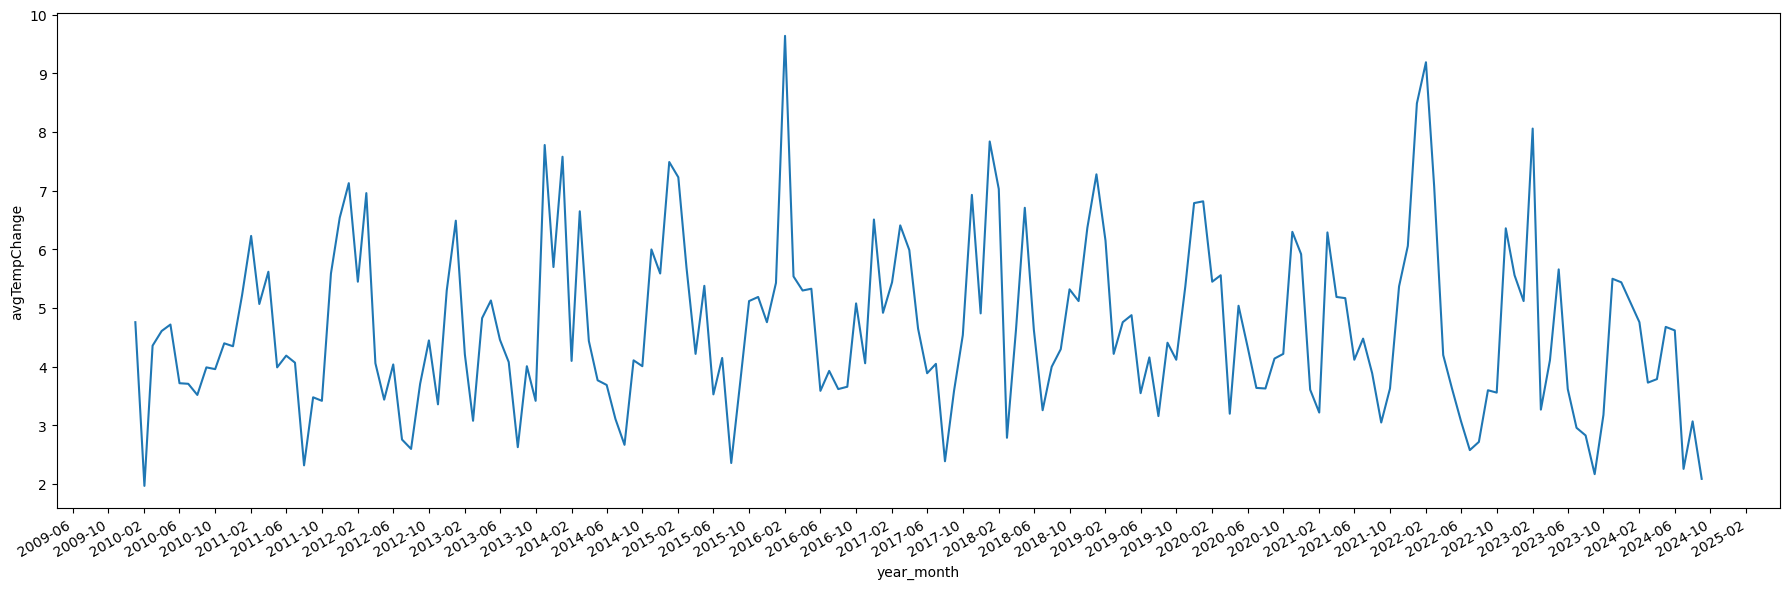

In [21]:
# Set the figure size
plt.figure(figsize=(18, 6))

# Create the line plot
sns.lineplot(data=result, x='year_month', y='avgTempChange')

# Set x-axis date format to show both year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set the tick frequency to display more dates (e.g., every month or every 3 months)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Shows every month

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### display avg, max and min temp change by month

In [22]:
df3.show()

+----+---+---+----+--------+------------------+
|year| mo| da|temp|pre_temp| daily_temp_change|
+----+---+---+----+--------+------------------+
|2010|  1|  1|29.6|    NULL|              NULL|
|2010|  1|  2|28.6|    29.6|               1.0|
|2010|  1|  3|22.3|    28.6| 6.300000000000001|
|2010|  1|  4|30.5|    22.3|               8.2|
|2010|  1|  5|29.2|    30.5|1.3000000000000007|
|2010|  1|  6|28.7|    29.2|               0.5|
|2010|  1|  7|30.9|    28.7|2.1999999999999993|
|2010|  1|  8|27.4|    30.9|               3.5|
|2010|  1|  9|22.9|    27.4|               4.5|
|2010|  1| 10|17.6|    22.9| 5.299999999999997|
|2010|  1| 11|25.2|    17.6| 7.599999999999998|
|2010|  1| 12|29.3|    25.2| 4.100000000000001|
|2010|  1| 13|20.3|    29.3|               9.0|
|2010|  1| 14|27.5|    20.3| 7.199999999999999|
|2010|  1| 15|35.6|    27.5| 8.100000000000001|
|2010|  1| 16|39.4|    35.6| 3.799999999999997|
|2010|  1| 17|37.3|    39.4|2.1000000000000014|
|2010|  1| 18|33.7|    37.3|3.5999999999

In [12]:
df4=df3.groupBy('year', 'mo').agg(F.round(F.avg('daily_temp_change'),2).alias('avgTempChange')
                                , F.round(F.min('daily_temp_change'),2).alias('minTempChange')
                               , F.round(F.max('daily_temp_change'),2).alias('maxTempChange')
                               )
df4.show()

+----+---+-------------+-------------+-------------+
|year| mo|avgTempChange|minTempChange|maxTempChange|
+----+---+-------------+-------------+-------------+
|2010|  1|         4.76|          0.1|         14.3|
|2010|  2|         1.97|          0.1|          4.9|
|2010|  3|         4.36|          0.2|         12.5|
|2010|  4|         4.61|          0.2|         10.9|
|2010|  5|         4.72|          0.2|         16.8|
|2010|  6|         3.72|          0.0|          9.2|
|2010|  7|         3.71|          0.2|          9.5|
|2010|  8|         3.52|          0.1|          8.8|
|2010|  9|         3.99|          0.2|         11.8|
|2010| 10|         3.96|          0.0|         14.3|
|2010| 11|          4.4|          0.1|         12.8|
|2010| 12|         4.35|          0.0|         17.8|
|2011|  1|         5.22|          0.0|         12.2|
|2011|  2|         6.23|          0.9|         16.6|
|2011|  3|         5.07|          0.0|         15.9|
|2011|  4|         5.62|          0.7|        

#### Visualize the result

In [13]:
result=df4.withColumn('year_month', F.to_date(F.concat_ws('-', df['year'], df['mo']), 'yyyy-MM'))

result.show(5)

+----+---+-------------+-------------+-------------+----------+
|year| mo|avgTempChange|minTempChange|maxTempChange|year_month|
+----+---+-------------+-------------+-------------+----------+
|2010|  1|         4.76|          0.1|         14.3|2010-01-01|
|2010|  2|         1.97|          0.1|          4.9|2010-02-01|
|2010|  3|         4.36|          0.2|         12.5|2010-03-01|
|2010|  4|         4.61|          0.2|         10.9|2010-04-01|
|2010|  5|         4.72|          0.2|         16.8|2010-05-01|
+----+---+-------------+-------------+-------------+----------+
only showing top 5 rows



In [14]:
result1=result.toPandas()

result1.head()

,year,mo,avgTempChange,minTempChange,maxTempChange,year_month
0,2010,1,4.76,0.1,14.3,2010-01-01
1,2010,2,1.97,0.1,4.9,2010-02-01
2,2010,3,4.36,0.2,12.5,2010-03-01
3,2010,4,4.61,0.2,10.9,2010-04-01
4,2010,5,4.72,0.2,16.8,2010-05-01


In [15]:
result2 = pd.melt(result1, id_vars=['year_month'], value_vars=['avgTempChange', 'maxTempChange', 'minTempChange'], 
                    var_name='temp_stat', value_name='temperature')

result2.head()

,year_month,temp_stat,temperature
0,2010-01-01,avgTempChange,4.76
1,2010-02-01,avgTempChange,1.97
2,2010-03-01,avgTempChange,4.36
3,2010-04-01,avgTempChange,4.61
4,2010-05-01,avgTempChange,4.72


Text(0, 0.5, 'Taemperature Change')

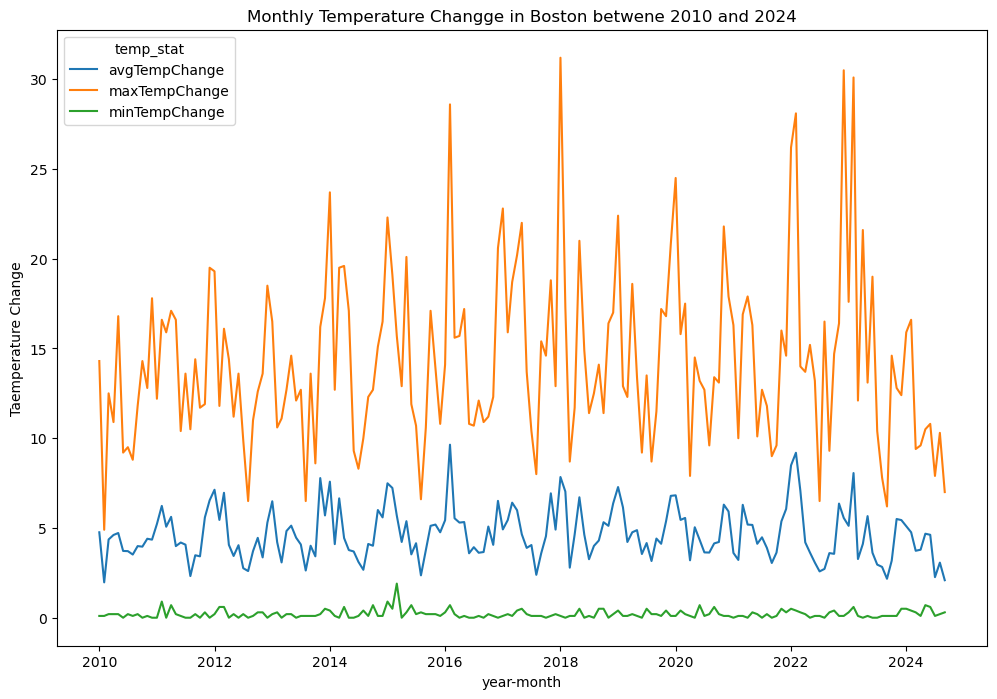

In [17]:
plt.figure(figsize=(12, 8))

sns.lineplot(data=result2, x='year_month', y='temperature', hue='temp_stat')

plt.title('Monthly Temperature Changge in Boston betwene 2010 and 2024')
plt.xlabel('year-month')
plt.ylabel('Taemperature Change')

## Spark also provides the rowsBetween() and rangeBetween() methods to create window frame boundaries.

### Display three days moving average temp for each month

In [28]:
windowSpec=Window.partitionBy('year', 'mo').orderBy('da').rowsBetween(-2,0)

df1=df.withColumn('3_day_moving_avg', F.avg('temp').over(windowSpec))

df1.show()

+----+---+---+----+----------+----------+------------------+
|year| mo| da|temp|      date|year_month|  3_day_moving_avg|
+----+---+---+----+----------+----------+------------------+
|2010|  1|  1|29.6|2010-01-01|2010-01-01|              29.6|
|2010|  1|  2|28.6|2010-01-02|2010-01-01|              29.1|
|2010|  1|  3|22.3|2010-01-03|2010-01-01|26.833333333333332|
|2010|  1|  4|30.5|2010-01-04|2010-01-01|27.133333333333336|
|2010|  1|  5|29.2|2010-01-05|2010-01-01|27.333333333333332|
|2010|  1|  6|28.7|2010-01-06|2010-01-01| 29.46666666666667|
|2010|  1|  7|30.9|2010-01-07|2010-01-01|29.599999999999998|
|2010|  1|  8|27.4|2010-01-08|2010-01-01|              29.0|
|2010|  1|  9|22.9|2010-01-09|2010-01-01|27.066666666666663|
|2010|  1| 10|17.6|2010-01-10|2010-01-01|22.633333333333336|
|2010|  1| 11|25.2|2010-01-11|2010-01-01|21.900000000000002|
|2010|  1| 12|29.3|2010-01-12|2010-01-01| 24.03333333333333|
|2010|  1| 13|20.3|2010-01-13|2010-01-01|24.933333333333334|
|2010|  1| 14|27.5|2010-

# Summary

- Window functions are functions that are applied over a portion of a data frame called a window frame. They can perform aggregation, ranking, or analytical operations. A window function will return the data frame with the same number of records, unlike its siblings the groupby-aggregate operation and the group map UDF.
- A window frame is defined through a window spec. A window spec mandates how the data frame is split (partitionBy()), how it’s ordered (orderBy()), and how it’s portioned (rowsBetween()/rangeBetween()).
- By default, an unordered window frame will be unbounded, meaning that the window frame will be equal to the window partition for every record. An ordered window frame will grow to the left, meaning that each record will have a window frame ranging from the first record in the window partition to the current record.
- A window can be bounded by row, meaning that the records included in the window frame are tied to the row boundaries passed as parameters (with the range boundaries added to the row number of the current row), or by range, meaning that the records included in the window frame depend on the value of the current row (with the range boundaries added to the value).